<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/bayes_stats/linreg_hbayes_1d_pymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we illustrate hierarchical Bayesian linear regression on a toy 1d dataset.

The code is based on [Bayesian Analysis with Python, ch 3](https://github.com/aloctavodia/BAP/blob/master/code/Chp3/03_Modeling%20with%20Linear%20Regressions.ipynb) and [this blog post from Thomas Wiecki](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/GLM_hierarchical_non_centered.ipynb).

In [3]:
%matplotlib inline
import sklearn
import scipy.stats as stats
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import os
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [1]:

!pip install pymc3==3.8
import pymc3 as pm
pm.__version__


!pip install arviz
import arviz as az

[0.88022503 0.50983392 0.61314719 0.31763509 0.17516902 0.46602537
 0.57693427 0.84366837]


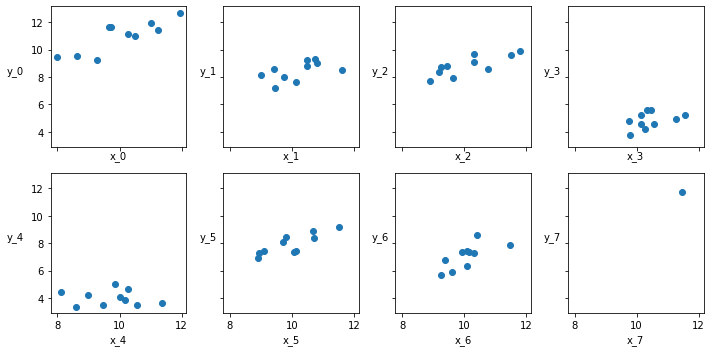

In [11]:
N = 10 #20
M = 8 # num groups
idx = np.repeat(range(M-1), N) # N samples for groups 0-6
idx = np.append(idx, 7) # 1 sample for 7'th group
np.random.seed(123)

#alpha_real = np.random.normal(2.5, 0.5, size=M)
#beta_real = np.random.beta(6, 1, size=M)
#eps_real = np.random.normal(0, 0.5, size=len(idx))

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(1, 1, size=M) # slope is closer to 0
eps_real = np.random.normal(0, 0.5, size=len(idx))

print(beta_real)

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real
x_centered = x_m - x_m.mean()

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    #ax[i].set_xlim(6, 15)
    #ax[i].set_ylim(1, 18)
    j += N
    k += N
plt.tight_layout()

In [5]:
# Fit separarate models per group

with pm.Model() as unpooled_model:
    α = pm.Normal('α', mu=0, sd=10, shape=M)
    β = pm.Normal('β', mu=0, sd=10, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)

    y_pred = pm.Normal('y_pred', mu=α[idx] + β[idx] * x_m,
                         sd=ϵ,  observed=y_m)
    trace_up = pm.sample(1000)

az.summary(trace_up)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β, α]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:19<00:00, 76.68it/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α[0],2.749,1.645,-0.314,5.723,0.036,0.026,2125.0,1993.0,2132.0,1486.0,1.00
α[1],3.116,2.507,-1.687,7.561,0.051,0.047,2455.0,1395.0,2506.0,1305.0,1.00
α[2],2.900,2.017,-0.841,6.609,0.052,0.040,1493.0,1289.0,1502.0,1282.0,1.00
α[3],0.630,3.235,-5.386,6.556,0.065,0.071,2494.0,1052.0,2484.0,1361.0,1.00
α[4],4.467,1.946,1.228,8.495,0.047,0.034,1686.0,1686.0,1692.0,1369.0,1.00
α[5],0.315,2.317,-3.947,4.733,0.048,0.054,2315.0,930.0,2340.0,1412.0,1.00
α[6],-2.924,3.008,-7.909,3.450,0.062,0.052,2371.0,1648.0,2380.0,1305.0,1.01
α[7],-0.019,10.236,-18.613,19.346,0.199,0.247,2653.0,859.0,2646.0,1285.0,1.00
β[0],0.822,0.163,0.524,1.124,0.004,0.003,2131.0,2038.0,2143.0,1416.0,1.00
β[1],0.523,0.245,0.080,0.990,0.005,0.004,2427.0,2277.0,2478.0,1287.0,1.00


In [0]:
def plot_post_pred_samples(trace, nsamples=20):
    _, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
                       constrained_layout=True)
    ax = np.ravel(ax)
    j, k = 0, N
    x_range = np.linspace(x_m.min(), x_m.max(), 10)
    X =  x_range[:, np.newaxis]
    
    for i in range(M):
        ax[i].scatter(x_m[j:k], y_m[j:k])
        ax[i].set_xlabel(f'x_{i}')
        ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
        alpha_m = trace['α'][:, i].mean()
        beta_m = trace['β'][:, i].mean()
        ax[i].plot(x_range, alpha_m + beta_m * x_range, c='r', lw=3,
                  label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
        plt.xlim(x_m.min()-1, x_m.max()+1)
        plt.ylim(y_m.min()-1, y_m.max()+1)
        alpha_samples = trace['α'][:,i]
        beta_samples = trace['β'][:,i]
        ndx = np.random.choice(np.arange(len(alpha_samples)), nsamples)
        alpha_samples_thinned = alpha_samples[ndx]
        beta_samples_thinned = beta_samples[ndx]
        ax[i].plot(x_range, alpha_samples_thinned + beta_samples_thinned * X,
            c='gray', alpha=0.5)
        
        j += N
        k += N

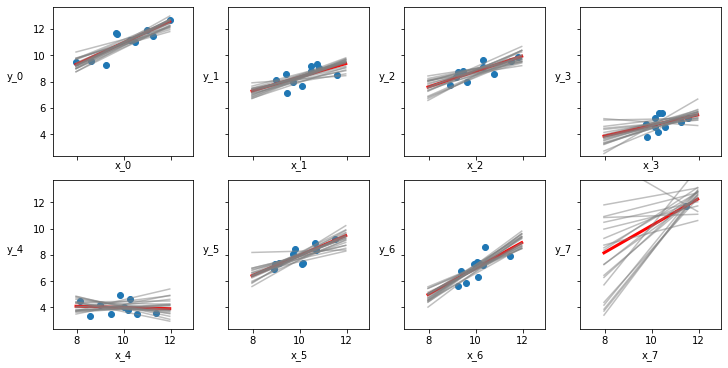

In [7]:
plot_post_pred_samples(trace_up)

In [8]:
# Fit a hierarchical (centered) model to the raw data
with pm.Model() as model_centered:
    # hyper-priors
    μ_α = pm.Normal('μ_α', mu=0, sd=10)
    σ_α = pm.HalfNormal('σ_α', 10)
    μ_β = pm.Normal('μ_β', mu=0, sd=10)
    σ_β = pm.HalfNormal('σ_β', sd=10)

    # priors
    α = pm.Normal('α', mu=μ_α, sd=σ_α, shape=M)
    β = pm.Normal('β', mu=μ_β, sd=σ_β, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)

    y_pred = pm.Normal('y_pred', mu=α[idx] + β[idx] * x_m,
                         sd=ϵ, observed=y_m)

    trace_centered = pm.sample(1000)

az.summary(trace_centered)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β, α, σ_β, μ_β, σ_α, μ_α]
Sampling chain 1, 19 divergences: 100%|██████████| 1500/1500 [00:13<00:00, 113.79it/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ_α,2.263,1.008,0.412,4.178,0.044,0.031,523.0,523.0,520.0,1053.0,1.00
μ_β,0.553,0.135,0.306,0.810,0.005,0.004,659.0,637.0,650.0,1034.0,1.00
α[0],2.847,1.135,0.709,5.099,0.045,0.033,627.0,578.0,631.0,850.0,1.00
α[1],2.550,1.271,0.225,4.979,0.048,0.034,696.0,696.0,655.0,1135.0,1.00
α[2],2.596,1.200,0.379,4.945,0.046,0.033,674.0,674.0,665.0,1041.0,1.01
α[3],1.619,1.488,-1.498,4.060,0.068,0.048,478.0,478.0,481.0,866.0,1.00
α[4],2.291,1.319,-0.066,4.919,0.050,0.036,686.0,686.0,676.0,1031.0,1.00
α[5],1.975,1.283,-0.376,4.420,0.050,0.035,665.0,665.0,642.0,1110.0,1.00
α[6],1.526,1.536,-1.476,4.132,0.073,0.052,445.0,445.0,462.0,650.0,1.00
α[7],2.787,1.634,-0.208,5.989,0.060,0.046,745.0,634.0,698.0,877.0,1.00


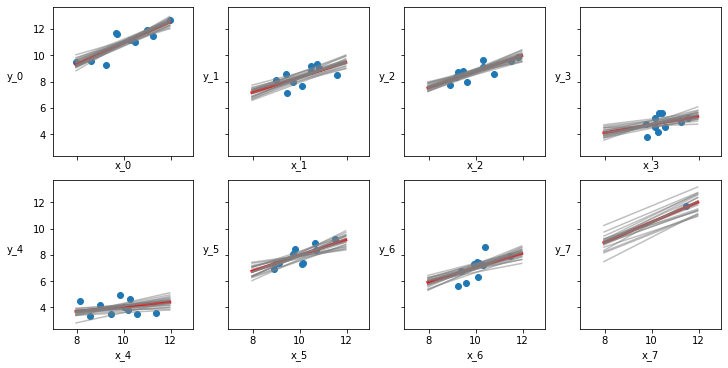

In [9]:
plot_post_pred_samples(trace_centered)

In [10]:
# Fit the non-centered model to the raw data
with pm.Model() as model_noncentered:
    # hyper-priors
    μ_α = pm.Normal('μ_α', mu=0, sd=10)
    σ_α = pm.HalfNormal('σ_α', 10)
    μ_β = pm.Normal('μ_β', mu=0, sd=10)
    σ_β = pm.HalfNormal('σ_β', sd=10)

    # priors
    α_offset = pm.Normal('α_offset', mu=0, sd=1, shape=M)
    α = pm.Deterministic('α', μ_α + σ_α * α_offset) 
    β_offset = pm.Normal('β_offset', mu=0, sd=1, shape=M)
    β = pm.Deterministic('β', μ_β + σ_β * β_offset) 

    ϵ = pm.HalfCauchy('ϵ', 5)

    y_pred = pm.Normal('y_pred', mu=α[idx] + β[idx] * x_m,
                         sd=ϵ, observed=y_m)

    trace_noncentered = pm.sample(1000)

az.summary(trace_noncentered)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β_offset, α_offset, σ_β, μ_β, σ_α, μ_α]
Sampling chain 1, 8 divergences: 100%|██████████| 1500/1500 [00:25<00:00, 59.32it/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ_α,2.260,1.000,0.503,4.166,0.027,0.019,1358.0,1358.0,1351.0,718.0,1.00
μ_β,0.548,0.144,0.272,0.814,0.006,0.004,644.0,588.0,668.0,742.0,1.00
α_offset[0],0.363,0.844,-1.133,2.053,0.022,0.020,1437.0,867.0,1461.0,866.0,1.00
α_offset[1],0.157,0.872,-1.613,1.699,0.018,0.021,2242.0,844.0,2227.0,1287.0,1.00
α_offset[2],0.183,0.835,-1.386,1.731,0.020,0.018,1791.0,1028.0,1814.0,1507.0,1.00
α_offset[3],-0.406,0.917,-1.984,1.361,0.021,0.020,1947.0,1076.0,1948.0,1518.0,1.00
α_offset[4],0.036,0.878,-1.596,1.723,0.022,0.023,1602.0,761.0,1582.0,1393.0,1.00
α_offset[5],-0.181,0.871,-1.858,1.406,0.021,0.021,1645.0,838.0,1693.0,687.0,1.00
α_offset[6],-0.443,0.903,-2.110,1.333,0.022,0.020,1698.0,1033.0,1685.0,832.0,1.00
α_offset[7],0.276,0.966,-1.455,2.113,0.023,0.022,1700.0,964.0,1704.0,1450.0,1.00


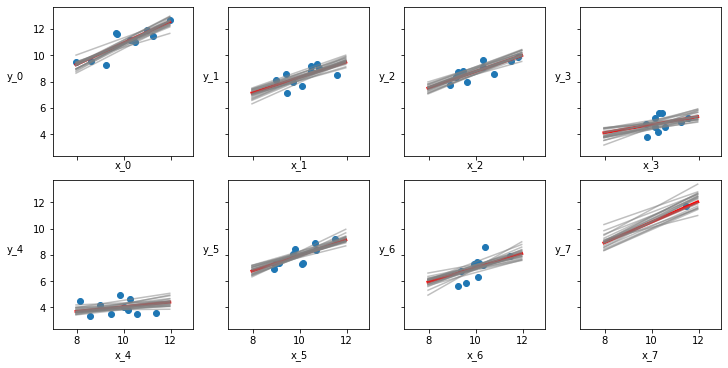

In [12]:
plot_post_pred_samples(trace_noncentered)